Epoch 1/6, Loss: 0.035450
Epoch 2/6, Loss: 0.026411
Epoch 3/6, Loss: 0.023727
Epoch 4/6, Loss: 0.023105
Epoch 5/6, Loss: 0.022783
Epoch 6/6, Loss: 0.022557


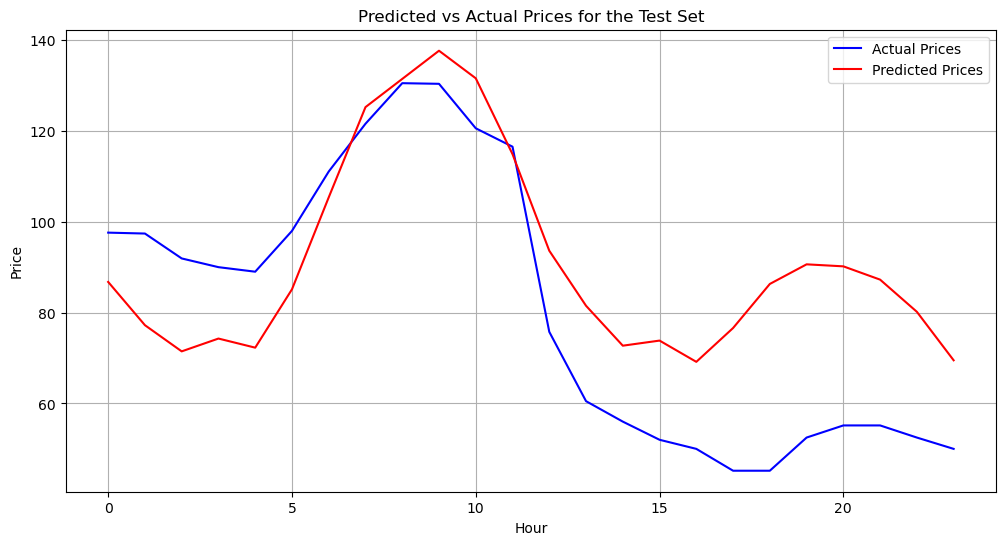

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# File paths
file_path = '../TrainingData/trainingdata_23_24.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32

# Load data in chunks and split into training and test datasets
train_data = []
test_data = []
test_split_ratio = 0.1  # Use the last 10% for testing

# Initialize separate scalers for Price1 and Price2
scaler_price1 = MinMaxScaler(feature_range=(0, 1))
scaler_price2 = MinMaxScaler(feature_range=(0, 1))
scaler_features = MinMaxScaler(feature_range=(0, 1))  # For other features

# Read the file in chunks
chunksize = 10_000
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    # Prepare input features and target prices
    price1 = chunk[['Price1']].values
    price2 = chunk[['Price2']].values
    features = chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values

    # Fit scalers on the entire dataset
    scaler_price1.partial_fit(price1)
    scaler_price2.partial_fit(price2)
    scaler_features.partial_fit(features)

# Second pass to transform data
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    # Prepare input features and target prices
    price1_scaled = scaler_price1.transform(chunk[['Price1']].values)
    price2_scaled = scaler_price2.transform(chunk[['Price2']].values)
    features_scaled = scaler_features.transform(chunk[['Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values)

    # Combine scaled features
    combined_features = np.hstack([price1_scaled, price2_scaled, features_scaled])

    if len(combined_features) < sequence_length + output_sequence_length:
        continue  # Skip chunks that are too small for the sequence lengths

    X, y = [], []
    for i in range(len(combined_features) - sequence_length - output_sequence_length):
        X.append(combined_features[i:i + sequence_length])  # Input sequence
        y.append(price1_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Target sequence
    
    if len(test_data) == 0:  # Reserve the last portion of the data for testing
        test_start_idx = int(len(X) * (1 - test_split_ratio))
        train_data.append((X[:test_start_idx], y[:test_start_idx]))
        test_data = (X[test_start_idx:], y[test_start_idx:])
    else:
        train_data.append((X, y))

# Combine training data
X_train = np.concatenate([data[0] for data in train_data], axis=0)
y_train = np.concatenate([data[1] for data in train_data], axis=0)

# Prepare test data
X_test, y_test = np.array(test_data[0]), np.array(test_data[1])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define LSTM model (as in your code)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 6
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# Model evaluation and visualization
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Rescale predictions and actual values for Price1
y_test_pred_rescaled = scaler_price1.inverse_transform(y_test_pred)
y_test_actual_rescaled = scaler_price1.inverse_transform(y_test.numpy())

# Plotting predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual_rescaled[0])), y_test_actual_rescaled[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred_rescaled[0])), y_test_pred_rescaled[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


### Visualization of Predictions ###
Best Performance (Index: 150) - RMSE: 6.13, MAPE: 6.36%, R-squared: 0.83


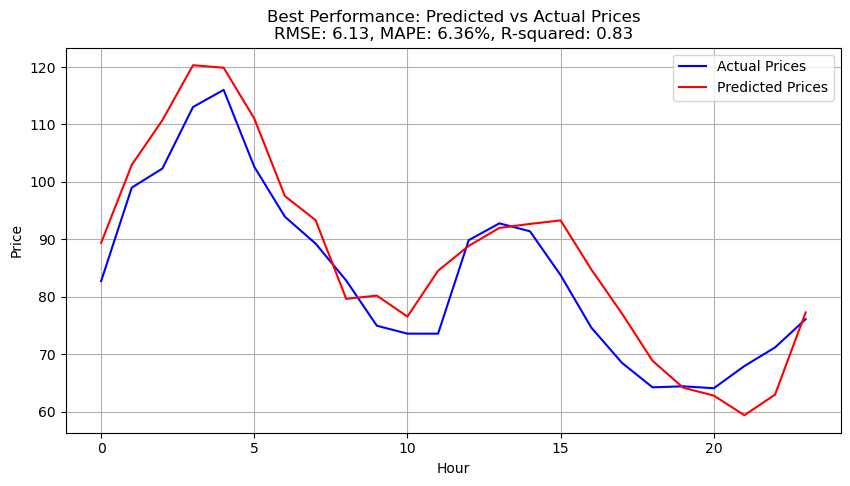

Worst Performance (Index: 708) - RMSE: 74.84, MAPE: 56.13%, R-squared: -14.72


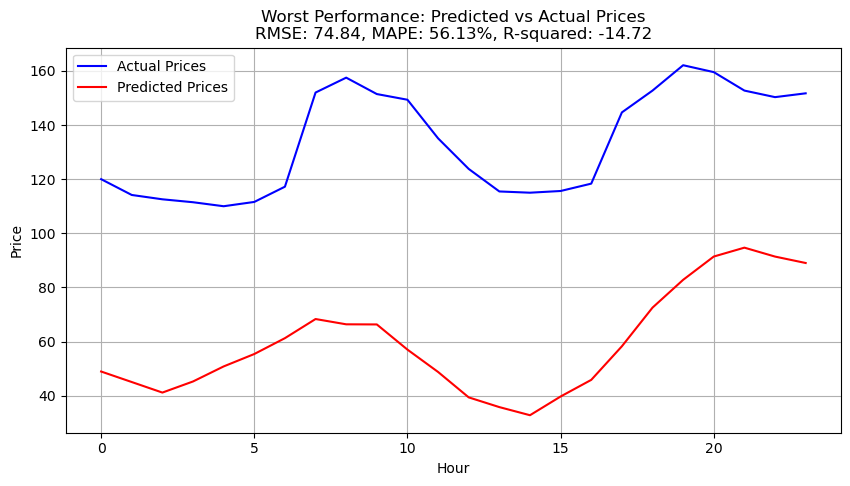

Median Performance (Index: 893) - RMSE: 25.94, MAPE: 18.38%, R-squared: 0.26


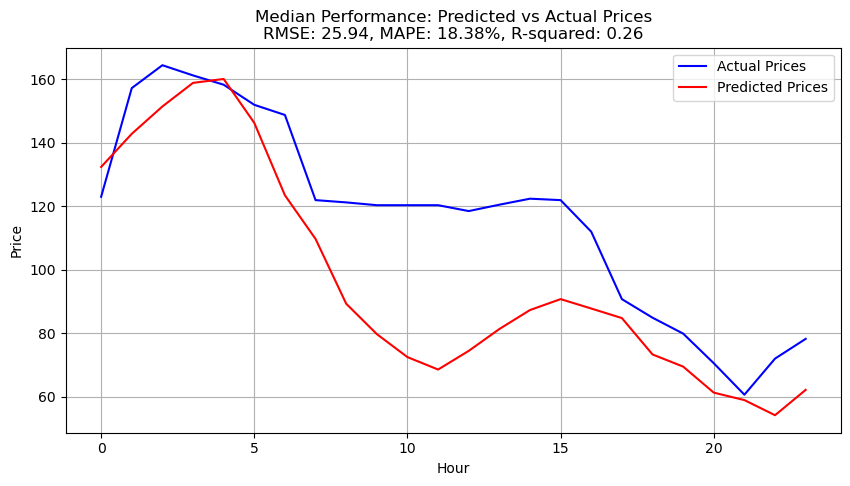

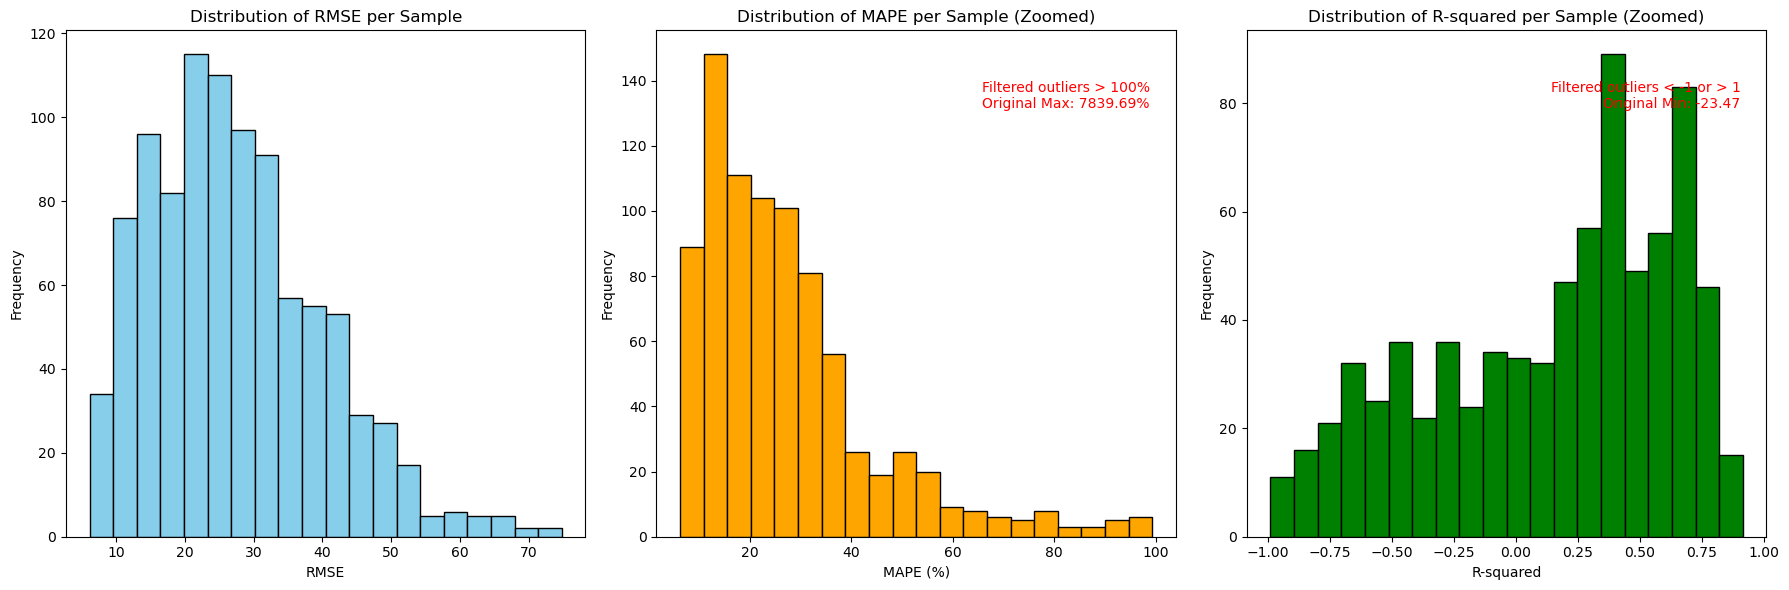


### Per-Sample Metrics Summary (Original Data) ###
Average RMSE: 27.37
Average MAPE: 179.14%
Average R-squared: -0.68
Maximum RMSE: 74.84
Minimum RMSE: 6.13
Maximum MAPE: 7839.69%
Minimum MAPE: 6.20%
Maximum R-squared: 0.91
Minimum R-squared: -23.47

### Filtered Metrics Summary (Excluding Extreme Outliers) ###
Filtered MAPE (Max): 99.38%
Filtered R-squared (Min): -0.99


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data using PyTorch
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()  # Get predictions as numpy array

# Inverse transform predictions and actual values for Price1
y_test_pred = scaler_price1.inverse_transform(y_test_pred)
y_test_actual = scaler_price1.inverse_transform(y_test.numpy())

# Calculate RMSE, MAPE, and R-squared for each sample
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []

for actual, predicted in zip(y_test_actual, y_test_pred):
    rmse_per_sample.append(np.sqrt(mean_squared_error(actual, predicted)))
    mape_per_sample.append(np.mean(np.abs((actual - predicted) / actual)) * 100)
    r2_per_sample.append(r2_score(actual, predicted))

# Find indices for best, median, and worst performance based on RMSE
best_index = np.argmin(rmse_per_sample)
worst_index = np.argmax(rmse_per_sample)
median_index = np.argsort(rmse_per_sample)[len(rmse_per_sample) // 2]

# Function to visualize a single prediction vs. actual with metrics
def plot_prediction_with_metrics(index, title):
    actual = y_test_actual[index]
    predicted = y_test_pred[index]
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(predicted, label="Predicted Prices", color="red")
    plt.title(f"{title}\nRMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R-squared: {r2:.2f}")
    plt.xlabel("Hour")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize worst, best, and median performances
print("### Visualization of Predictions ###")
print(f"Best Performance (Index: {best_index}) - RMSE: {rmse_per_sample[best_index]:.2f}, "
      f"MAPE: {mape_per_sample[best_index]:.2f}%, R-squared: {r2_per_sample[best_index]:.2f}")
plot_prediction_with_metrics(best_index, "Best Performance: Predicted vs Actual Prices")

print(f"Worst Performance (Index: {worst_index}) - RMSE: {rmse_per_sample[worst_index]:.2f}, "
      f"MAPE: {mape_per_sample[worst_index]:.2f}%, R-squared: {r2_per_sample[worst_index]:.2f}")
plot_prediction_with_metrics(worst_index, "Worst Performance: Predicted vs Actual Prices")

print(f"Median Performance (Index: {median_index}) - RMSE: {rmse_per_sample[median_index]:.2f}, "
      f"MAPE: {mape_per_sample[median_index]:.2f}%, R-squared: {r2_per_sample[median_index]:.2f}")
plot_prediction_with_metrics(median_index, "Median Performance: Predicted vs Actual Prices")

# Plot histograms of metrics distributions with filtered ranges
plt.figure(figsize=(18, 6))

# RMSE distribution
plt.subplot(1, 3, 1)
plt.hist(rmse_per_sample, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of RMSE per Sample")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

# MAPE distribution (filter extreme outliers)
filtered_mape = [m for m in mape_per_sample if m < 100]  # Exclude outliers beyond 100%
plt.subplot(1, 3, 2)
plt.hist(filtered_mape, bins=20, color="orange", edgecolor="black")
plt.title("Distribution of MAPE per Sample (Zoomed)")
plt.xlabel("MAPE (%)")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers > 100%\nOriginal Max: {np.max(mape_per_sample):.2f}%",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

# R-squared distribution (focus on meaningful range)
filtered_r2 = [r for r in r2_per_sample if -1 <= r <= 1]  # Exclude extreme values
plt.subplot(1, 3, 3)
plt.hist(filtered_r2, bins=20, color="green", edgecolor="black")
plt.title("Distribution of R-squared per Sample (Zoomed)")
plt.xlabel("R-squared")
plt.ylabel("Frequency")
plt.text(0.95, 0.9, f"Filtered outliers < -1 or > 1\nOriginal Min: {np.min(r2_per_sample):.2f}",
         transform=plt.gca().transAxes, fontsize=10, ha='right', va='top', color='red')

plt.tight_layout()
plt.show()

# Updated Summary Statistics (original data)
print("\n### Per-Sample Metrics Summary (Original Data) ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Average R-squared: {np.mean(r2_per_sample):.2f}")
print(f"Maximum RMSE: {np.max(rmse_per_sample):.2f}")
print(f"Minimum RMSE: {np.min(rmse_per_sample):.2f}")
print(f"Maximum MAPE: {np.max(mape_per_sample):.2f}%")
print(f"Minimum MAPE: {np.min(mape_per_sample):.2f}%")
print(f"Maximum R-squared: {np.max(r2_per_sample):.2f}")
print(f"Minimum R-squared: {np.min(r2_per_sample):.2f}")

# Additional Summary (filtered data)
print("\n### Filtered Metrics Summary (Excluding Extreme Outliers) ###")
print(f"Filtered MAPE (Max): {np.max(filtered_mape):.2f}%")
print(f"Filtered R-squared (Min): {np.min(filtered_r2):.2f}")




In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# File paths
file_path = '../TrainingData/trainingdata_23_24.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32

# Load data in chunks and split into training and test datasets
train_data = []
test_data = []
test_split_ratio = 0.1  # Use the last 10% for testing

# Initialize scalers
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Read the file in chunks
chunksize = 10_000
reader = pd.read_csv(file_path, chunksize=chunksize)

for chunk in reader:
    # Prepare input features and target prices
    features = chunk[['Price1', 'Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values
    features_scaled = scaler_X.fit_transform(features)
    
    if len(features_scaled) < sequence_length + output_sequence_length:
        continue  # Skip chunks that are too small for the sequence lengths

    X, y = [], []
    for i in range(len(features_scaled) - sequence_length - output_sequence_length):
        X.append(features_scaled[i:i + sequence_length])  # Input sequence
        y.append(features_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Target sequence
    
    if len(test_data) == 0:  # Reserve the last portion of the data for testing
        test_start_idx = int(len(X) * (1 - test_split_ratio))
        train_data.append((X[:test_start_idx], y[:test_start_idx]))
        test_data = (X[test_start_idx:], y[test_start_idx:])
    else:
        train_data.append((X, y))

# Combine training data
X_train = np.concatenate([data[0] for data in train_data], axis=0)
y_train = np.concatenate([data[1] for data in train_data], axis=0)

# Prepare test data
X_test, y_test = np.array(test_data[0]), np.array(test_data[1])

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define LSTM model (as in your code)
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parameters
input_size = X_train.shape[2]
hidden_size = 50
output_size = output_sequence_length

model = LSTMModel(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# Model evaluation and visualization
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).numpy()

# Rescale predictions and actual values
y_test_pred = scaler_y.inverse_transform(y_test_pred)
y_test_actual = scaler_y.inverse_transform(y_test.numpy())

# Plotting predictions vs actual (reuse the earlier visualization code)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test_actual[0])), y_test_actual[0], label="Actual Prices", color="blue")
plt.plot(range(len(y_test_pred[0])), y_test_pred[0], label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


KeyboardInterrupt: 

In [27]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('../TrainingData/trainingdata23.csv')

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history (24 * 14 = 336 hours)
output_sequence_length = 24  # Predict the next 24 hours

# Extract features and target column
features = data[['Price1', 'Price2', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos', 'Month_Sin', 'Month_Cos']].values

# Scale features
scaler_X = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_X.fit_transform(features)

# Prepare input-output sequences
X, y = [], []
for i in range(len(features) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input: last 2 weeks
    y.append(features_scaled[i + sequence_length:i + sequence_length + output_sequence_length, 0])  # Output: next 24 hours of `Price1`

X = np.array(X)
y = np.array(y)

# Split the last 24 hours as the test set
X_train, y_train = X[:-5], y[:-5]  # Use all but the last 24 hours for training
X_test, y_test = X[-5:], y[-5:]    # Use only the last 24 hours for testing

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last LSTM output
        return out

# Model parameters
input_dim = X_train.shape[2]
hidden_dim = 20
output_dim = output_sequence_length
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 40
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/40, Loss: 14.6413
Epoch 2/40, Loss: 7.9406
Epoch 3/40, Loss: 6.9198
Epoch 4/40, Loss: 6.3637
Epoch 5/40, Loss: 5.7745
Epoch 6/40, Loss: 5.6132
Epoch 7/40, Loss: 5.4762
Epoch 8/40, Loss: 5.4168
Epoch 9/40, Loss: 5.3548
Epoch 10/40, Loss: 5.3325
Epoch 11/40, Loss: 5.3111
Epoch 12/40, Loss: 5.2581
Epoch 13/40, Loss: 5.2270
Epoch 14/40, Loss: 5.2029
Epoch 15/40, Loss: 5.1725
Epoch 16/40, Loss: 5.1506
Epoch 17/40, Loss: 5.1428
Epoch 18/40, Loss: 5.1116
Epoch 19/40, Loss: 5.0842
Epoch 20/40, Loss: 5.0559
Epoch 21/40, Loss: 5.0604
Epoch 22/40, Loss: 5.0004
Epoch 23/40, Loss: 4.9917
Epoch 24/40, Loss: 4.9720
Epoch 25/40, Loss: 4.8957
Epoch 26/40, Loss: 4.8598
Epoch 27/40, Loss: 4.7926
Epoch 28/40, Loss: 4.7194
Epoch 29/40, Loss: 4.6962
Epoch 30/40, Loss: 4.6319
Epoch 31/40, Loss: 4.5495
Epoch 32/40, Loss: 4.5248
Epoch 33/40, Loss: 4.4231
Epoch 34/40, Loss: 4.3338
Epoch 35/40, Loss: 4.2807
Epoch 36/40, Loss: 4.2119
Epoch 37/40, Loss: 4.1821
Epoch 38/40, Loss: 4.1778
Epoch 39/40, Loss: 4

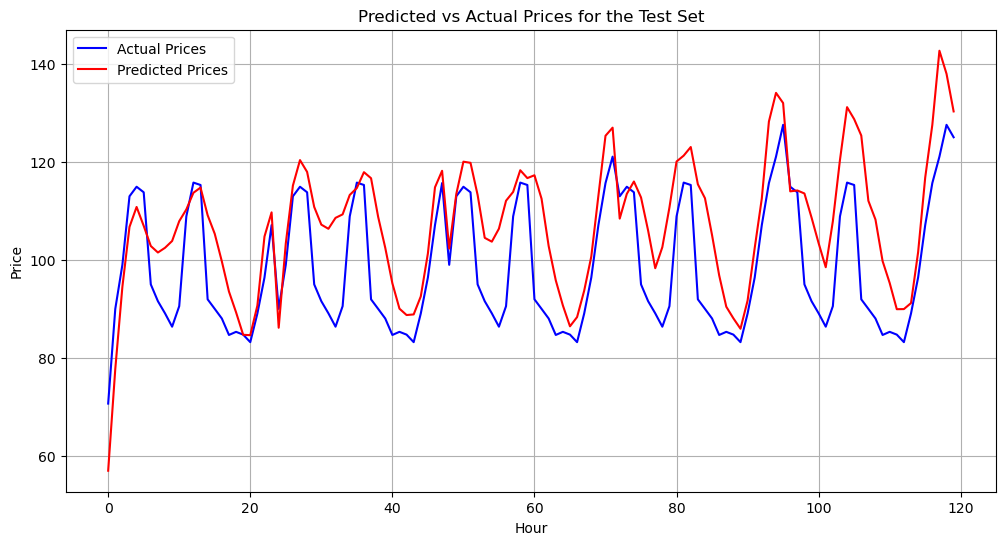

In [29]:
# Evaluate on Test Set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).numpy()  # Shape: (batch_size, output_sequence_length)
    test_actual = y_test.numpy()  # Shape: (batch_size, output_sequence_length)

# Ensure both arrays are 2D and have matching shapes
test_predictions = test_predictions.reshape(-1, test_predictions.shape[-1])  # (num_samples, output_sequence_length)
test_actual = test_actual.reshape(-1, test_actual.shape[-1])  # (num_samples, output_sequence_length)

# Use scaler_y to inverse transform predictions and actuals
test_predictions_rescaled = scaler_y.inverse_transform(test_predictions)
test_actual_rescaled = scaler_y.inverse_transform(test_actual)

# Flatten both arrays for plotting
test_predictions_flat = test_predictions_rescaled.flatten()  # Shape: (num_samples * output_sequence_length,)
test_actual_flat = test_actual_rescaled.flatten()  # Shape: (num_samples * output_sequence_length,)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_actual_flat)), test_actual_flat, label="Actual Prices", color="blue")
plt.plot(range(len(test_predictions_flat)), test_predictions_flat, label="Predicted Prices", color="red")
plt.title("Predicted vs Actual Prices for the Test Set")
plt.xlabel("Hour")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test_actual_flat, test_predictions_flat))
print(f"RMSE: {rmse:.2f}")
mape = np.mean(np.abs((test_actual_flat - test_predictions_flat) / test_actual_flat)) * 100
print(f"MAPE: {mape:.2f}%")
from sklearn.metrics import r2_score

r2 = r2_score(test_actual_flat, test_predictions_flat)
print(f"R-squared: {r2:.2f}")



RMSE: 12.09
MAPE: 10.43%
R-squared: 0.15
